# Regression Tree

It's time to design our generic regression tree model that can be applied to any player. It will be based on the regression tree we designed using Federer as an exemple.

In [145]:
### IMPORTS ###

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

We select the player and generate a table containing that player's matches which we will store in "player.csv", as to avoid creating one table for each player.  
Note : This setup step has to be repeated each time we change players.

In [146]:
### CLEAN PLAYER MATCHES TABLES ###

PLAYER = "Rafael Nadal"
setup = True

if (setup) :    # Creating the table (if the player.csv table currently contains information for another player)

    atp = pd.read_csv("atp_cat.csv")

    player_won = atp[atp["winner_name"] == PLAYER]
    player_lost = atp[atp["loser_name"] == PLAYER]

    # We'll drop all of the player's information except his age and rank
    player_won = player_won.drop(labels=["winner_name", "winner_hand", "winner_ht", "winner_ioc"], axis=1)
    player_won = player_won.rename(columns={"winner_age": "player_age", "winner_rank": "player_rank", "winner_rank_points": "player_rank_points",
                                    "loser_name":"opp_name", "loser_hand":"opp_hand", "loser_ht":"opp_ht", "loser_ioc":"opp_ioc", "loser_age":"opp_age",
                                    "loser_rank": "opp_rank", "loser_rank_points": "opp_rank_points"})
    player_won["index2"] = player_won.index
    player_won["player_won"] = "1"

    player_lost = player_lost.drop(labels=["loser_name", "loser_hand", "loser_ht", "loser_ioc"], axis=1)
    player_lost = player_lost.rename(columns={"loser_age": "player_age", "loser_rank": "player_rank", "loser_rank_points": "player_rank_points",
                                        "winner_name":"opp_name", "winner_hand":"opp_hand", "winner_ht":"opp_ht", "winner_ioc":"opp_ioc", "winner_age":"opp_age",
                                        "winner_rank": "opp_rank", "winner_rank_points": "opp_rank_points"})
    player_lost["index2"] = player_lost.index
    player_lost["player_won"] = "0"

    player = pd.concat([player_won, player_lost])
    player = player.drop(["Unnamed: 0", "index2"] , axis=1)
    player.sort_index(inplace=True)

    # Win streaks
    result = player.player_won.astype(int)
    consecutive = result.groupby((result != result.shift()).cumsum()).cumcount()
    wins = pd.DataFrame({"win" : result, "consecutive" : consecutive})
    m = wins.win == 1
    wins.consecutive = wins.consecutive.where(m, 0)
    player["consecutive"] = wins.consecutive

    player.to_csv("player.csv")     # Saving the table for ease of use

else :  # player.csv already contains this player's information

    player = pd.read_csv("player.csv")

display(player)
print(f"{PLAYER} has {len(player)} recorded matches.")

,tourney_name,surface,tourney_level,tourney_date,player_age,opp_name,opp_hand,opp_ht,opp_ioc,opp_age,score,best_of,round,minutes,player_rank,player_rank_points,opp_rank,opp_rank_points,player_won,consecutive
36750,Mallorca,Clay,A,20020429,15.904175,Ramon Delgado,R,185.0,PAR,25.453799,6-4 6-4,3,R32,83.0,762.0,14.0,81.0,490.0,1,0
36763,Mallorca,Clay,A,20020429,15.904175,Olivier Rochus,R,168.0,BEL,21.275838,6-2 6-2,3,R16,62.0,762.0,14.0,70.0,571.0,0,0
37358,Bastad,Clay,A,20030707,17.092402,Younes El Aynaoui,R,193.0,MAR,31.816564,6-3 4-6 6-3,3,R32,102.0,61.0,639.0,21.0,1300.0,1,0
37368,Bastad,Clay,A,20030707,17.092402,Albert Portas,R,188.0,ESP,29.639973,6-0 6-4,3,R16,71.0,61.0,639.0,83.0,489.0,1,1
37373,Bastad,Clay,A,20030707,17.092402,Nicolas Lapentti,R,188.0,ECU,26.896646,3-6 6-3 7-6(6),3,QF,176.0,61.0,639.0,76.0,530.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85403,Roland Garros,Clay,G,20210531,34.992471,Jannik Sinner,R,188.0,ITA,19.789185,7-5 6-3 6-0,5,R16,137.0,3.0,9630.0,19.0,2500.0,1,10
85410,Roland Garros,Clay,G,20210531,34.992471,Diego Schwartzman,R,170.0,ARG,28.788501,6-3 4-6 6-4 6-0,5,QF,165.0,3.0,9630.0,10.0,3465.0,1,11
85413,Roland Garros,Clay,G,20210531,34.992471,Novak Djokovic,R,188.0,SRB,34.026010,3-6 6-3 7-6(4) 6-2,5,SF,251.0,3.0,9630.0,1.0,11313.0,0,0
85907,Washington,Hard,A,20210802,35.164956,Lloyd Harris,R,193.0,RSA,24.435318,6-4 1-6 6-4,3,R16,130.0,3.0,8270.0,50.0,1303.0,0,0


Rafael Nadal has 1172 recorded matches.


## Regression Decision Tree

We will create a decision tree using these features :
- Surface  
- Best of  
- Opponent hand  
- Opponent height  
- Opponent country  
- Ranking difference  
- Tournament level  
- Match round (QF, SF, F, etc...)
- Player form  

Some of these features seem irrelevant, and they probably are. However, since we will use GridSearchCV to perform feature selection, we will feed the model all the information we have and let it select what is important (ie. the optimal splits in terms of information gain).

### Formatting

The "player.csv" table contains many unecessary columns. Here, we create a player1 table containing all the features we potentially need for our model and format them correctly. Specifically, we use one-hot encoding to split categorical data into multiple boolean columns.

In [147]:
player1 = player[["minutes", "surface", "best_of", "opp_hand", "opp_ht", "opp_age", "tourney_level", "round"]]
player1["rank_diff"] = player["player_rank"] - player["opp_rank"]
player1["consecutive"] = player["consecutive"]


# One-Hot Encoding
player1 = pd.get_dummies(data=player1, columns=["surface", "best_of", "opp_hand", "tourney_level", "round"])

player1 = player1.dropna(axis=0, how='any')

player1 = player1.drop(["round_BR"] , axis=1)

player1.tail(5)

C:\Users\uporito\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\uporito\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,minutes,opp_ht,opp_age,rank_diff,consecutive,surface_Carpet,surface_Clay,surface_Grass,surface_Hard,best_of_3,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
85403,137.0,188.0,19.789185,-16.0,10,0,1,0,0,0,...,1,0,0,0,0,1,0,0,0,0
85410,165.0,170.0,28.788501,-7.0,11,0,1,0,0,0,...,1,0,0,1,0,0,0,0,0,0
85413,251.0,188.0,34.026010,2.0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
85907,130.0,193.0,24.435318,-47.0,0,0,0,0,1,1,...,0,0,0,0,0,1,0,0,0,0
85915,184.0,185.0,28.854209,-189.0,0,0,0,0,1,1,...,0,0,0,0,0,0,1,0,0,0


### Regression Decision Tree



#### Pre-processing

For pre-processing we have three options :
- not scaling x or y
- scaling both x and y
- scaling x but not y   
  
I feel like scaling gives us better results but adds a hurdle in interpreting the tree's visualization since it displays scaled values. We can scale both input and output values back, just not display them with sklearns's plot_tree (or any tree visualization that I've found so far). For now, the roundabout solution is just to print out the scaled input and output.

In [148]:
### PRE-PROCESSING ###

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

target='minutes'

scale_x = False
scale_y = False

def preprocessing(scale_x=False, scale_y=False) :

    # 1. X, y unscaled
    X = player1.drop([target], axis=1)
    y = np.asarray(player1[target])
    y = y.reshape(-1,1)

    xscaler = StandardScaler()
    yscaler = StandardScaler()

    if (scale_x) :
        print("Scaling X...")
        xscaler.fit(X[['opp_ht', 'opp_age', 'rank_diff']])
        X[['opp_ht', 'opp_age', 'rank_diff']] = xscaler.transform(X[['opp_ht', 'opp_age', 'rank_diff']])

    if (scale_y) :
        print("Scaling y...")
        yscaler.fit(y)
        y = yscaler.transform(y)

    display(pd.DataFrame(X).head())
    display(pd.DataFrame(y).head())

    return X, y, xscaler, yscaler

X, y, xscaler, yscaler = preprocessing(scale_x, scale_y)

,opp_ht,opp_age,rank_diff,consecutive,surface_Carpet,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
36750,185.0,25.453799,681.0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
36763,168.0,21.275838,692.0,0,0,1,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
37358,193.0,31.816564,40.0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
37368,188.0,29.639973,-22.0,1,0,1,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
37373,188.0,26.896646,-15.0,0,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0


,0
0,83.0
1,62.0
2,102.0
3,71.0
4,176.0


#### Building the tree

To build a good tree, we need to select values for the tree's parameters (e.g. max depth, minimum samples per leaf). We'll perform this "Hyperparameter Tuning" using GridSearchCV, a library which selects the best tree by trying every combination of parameters we give it and performing a cross validation. The trees are commpared based on the R² criteria.  
  
![score formula](res/score.png "sklearn score")  

In [149]:
### PARAMETER SELECTION ###

from sklearn.model_selection import GridSearchCV

params = {
    # "criterion":("squared_error", "friedman_mse", "absolute_error", "poisson"), 
    "max_depth":np.arange(3, 10), 
    "min_samples_leaf":np.arange(1, 80), 
    # "min_weight_fraction_leaf":[0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.075, 0.001], 
    # "max_features":np.arange(1, 25)
}

dtr = DecisionTreeRegressor(random_state=42)
dtr_cv = GridSearchCV(dtr, params, scoring="r2", n_jobs=-1, verbose=1, cv=10)

In [150]:
### CUSTOM PREDICTION ###

def custom_predict(dtr, scale_x, scale_y, height, age, rank_diff, consecutive, surface, best_of, hand, level, round) :
    # returns the predicted length of a match given a set of match conditions

    # surface : carpet(1), clay(2), grass(3), hard(4)
    # best of : 3(1), 5(2)
    # hand : left(1), right(2)
    # level : A(1), D(2), F(3), G(4), M(5)
    # round : F(1), QF(2), R128(3), R16(4), R32(5), R64(6), R(7), SF(8)

    surface_input = [0, 0, 0, 0]
    surface_input[surface - 1] = 1

    bo_input = [0, 0]
    bo_input[best_of - 1] = 1

    hand_input = [0, 0]
    hand_input[hand - 1] = 1

    level_input = [0, 0, 0, 0, 0]
    level_input[level - 1] = 1

    round_input = [0, 0, 0, 0, 0, 0, 0, 0]
    round_input[round - 1] = 1

    if (not scale_x and not scale_y) :  # 1. X, y unscaled
        input = [height, age, rank_diff] + [consecutive] + surface_input + bo_input + hand_input + level_input + round_input
        print("Input : ", input)

        input = [input]

        print("Prediction : ", dtr.predict(input), " minutes")

    # input = [180, 0, 0, 0, 1, 0, 0, 0, 1]

    elif (scale_x and scale_y) :    # 2. X, y scaled
        input = xscaler.transform([[height, age, rank_diff]])
        input = np.append(input[0], consecutive, surface_input + bo_input + hand_input + level_input + round_input)
        print("Scaled input : ", input)

        input = [input]

        print("Scaled Prediction : ", dtr.predict(input), " minutes")
        print("Prediction : ", yscaler.inverse_transform(dtr.predict(input)), " minutes")

    elif (scale_x and not scale_y) :    # 3. X scaled, y unscaled
        input = xscaler.transform([[height, age, rank_diff]]).tolist()
        input = np.append(input[0], [consecutive] + surface_input + bo_input + hand_input + level_input + round_input)
        print("Scaled input : ", input)
        
        input = [input]

        print("Prediction : ", dtr.predict(input)[0], " minutes")

    return(dtr.predict(input)[0])

# e.g. prediction = predict(scale_x, scale_y, 180, 22, 0, 0, 4, 1, 2, 4, 5)

In [155]:
### THE LOOP ###

test_scores = []
predictions = []

iter = 100

for i in range(iter) :

    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=.3)
    dtr_cv.fit(Xtrain, ytrain)

    best_params = dtr_cv.best_params_
    print(f"Best parameters: {best_params})")

    dtr = DecisionTreeRegressor(**best_params)
    dtr.fit(Xtrain, ytrain)

    # Testing :

    ypred = dtr.predict(Xtest)

    print(f"Training score {i+1} : ", dtr.score(Xtrain, ytrain))
    print(f"Testing score {i+1} : ", dtr.score(Xtest, ytest))
    test_scores.append(dtr.score(Xtest, ytest))

    # predictions.append(custom_predict(dtr, scale_x, scale_y, 175, 31.54, -98, 0, 4, 1, 2, 1, 4))      # 91 minutes
    predictions.append(custom_predict(dtr, scale_x, scale_y, 188, 22.76, -89, 2, 4, 1, 2, 1, 8))      # 116 minutes
    # predictions.append(custom_predict(dtr, scale_x, scale_y, 198, 24.66, -106, 3, 4, 1, 2, 1, 1))     # 107 minutes

print("------------------------------------------------------------------------------------------------")
print("Test scores : ", test_scores)
print("Test scores average : ", sum(test_scores)/len(test_scores))

average_prediction = sum(predictions) / len(predictions)

print("------------------------------------------------------------------------------------------------")
print(predictions)
print(f"Average predicted length : {average_prediction}")

Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 43})
Training score 1 :  0.34202224457332153
Testing score 1 :  0.31064023853769496
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [97.43518519]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2096 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 5466 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.3s finished


Best parameters: {'max_depth': 4, 'min_samples_leaf': 77})
Training score 2 :  0.3354005488675257
Testing score 2 :  0.28713715026388764
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [98.34259259]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    8.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 37})
Training score 3 :  0.36754705325015313
Testing score 3 :  0.28791997136537306
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [97.88888889]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    8.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 5, 'min_samples_leaf': 53})
Training score 4 :  0.3525232878180984
Testing score 4 :  0.29825858640550007
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [103.33333333]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 58})
Training score 5 :  0.33309863781616234
Testing score 5 :  0.3110130771935833
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [97.17821782]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 46})
Training score 6 :  0.35847668063176974
Testing score 6 :  0.27601262954145267
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [96.45528455]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    8.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 52})
Training score 7 :  0.3383654325886465
Testing score 7 :  0.3262829024417805
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [102.26666667]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   10.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 79})
Training score 8 :  0.3290390506232824
Testing score 8 :  0.3283903988305875
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [96.76271186]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   10.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 37})
Training score 9 :  0.4039050476790509
Testing score 9 :  0.1912187274182281
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [105.11637931]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   10.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 30})
Training score 10 :  0.404652660662259
Testing score 10 :  0.18117262280592805
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [104.63636364]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   11.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 57})
Training score 11 :  0.34207275225158007
Testing score 11 :  0.32502391130775987
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [101.70454545]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 79})
Training score 12 :  0.32315485170201397
Testing score 12 :  0.32265775552764564
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [103.32738095]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 44})
Training score 13 :  0.365203469614913
Testing score 13 :  0.2673962705963766
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [96.47058824]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 66})
Training score 14 :  0.3416333540517582
Testing score 14 :  0.28086167095022496
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [93.7755102]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 60})
Training score 15 :  0.3575966154878385
Testing score 15 :  0.2923512186149225
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [96.45205479]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 3824 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    8.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 38})
Training score 16 :  0.3449659100129785
Testing score 16 :  0.3436992503583953
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [99.07291667]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   10.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 73})
Training score 17 :  0.34870805161384455
Testing score 17 :  0.2923054108438824
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [113.2875]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   10.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 41})
Training score 18 :  0.35475696588957417
Testing score 18 :  0.29296279832658556
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [91.8877551]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   10.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 79})
Training score 19 :  0.3256653494941609
Testing score 19 :  0.33303087468302583
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [107.62025316]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 1})
Training score 20 :  0.36838432457024806
Testing score 20 :  0.2722725968378058
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [90.91943128]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   11.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 22})
Training score 21 :  0.40239021640328365
Testing score 21 :  0.2521708531122374
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [90.43636364]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   10.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 15})
Training score 22 :  0.35343862667050363
Testing score 22 :  0.30245609339423807
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [102.84916201]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   10.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 5, 'min_samples_leaf': 43})
Training score 23 :  0.38912319808180085
Testing score 23 :  0.2567705717328076
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [92.20754717]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   11.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 47})
Training score 24 :  0.35329574657830265
Testing score 24 :  0.28875600666855816
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [98.69230769]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   15.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 45})
Training score 25 :  0.37818840225246253
Testing score 25 :  0.23947452293974802
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [92.01036269]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 1104 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 3104 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   15.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 34})
Training score 26 :  0.37645162432494306
Testing score 26 :  0.2621237506378099
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [107.72727273]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   12.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 56})
Training score 27 :  0.34660784080123874
Testing score 27 :  0.30394702106608174
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [94.46766169]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   10.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 76})
Training score 28 :  0.33785947677491757
Testing score 28 :  0.31352562390726224
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [97.07633588]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   10.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 77})
Training score 29 :  0.3309777186244506
Testing score 29 :  0.30815531868819157
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [108.12987013]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 37})
Training score 30 :  0.33697114357317304
Testing score 30 :  0.3391688819163574
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [104.14723926]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 74})
Training score 31 :  0.34690613401730697
Testing score 31 :  0.27199418361140604
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [97.75824176]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 77})
Training score 32 :  0.3245544500884451
Testing score 32 :  0.32788478629770057
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [101.41201717]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 45})
Training score 33 :  0.36558742984232506
Testing score 33 :  0.29712031108494497
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [100.71794872]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 44})
Training score 34 :  0.34586727285474983
Testing score 34 :  0.31859081843892967
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [91.74545455]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3824 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 45})
Training score 35 :  0.34207161695459554
Testing score 35 :  0.3453836856177095
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [98.32786885]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   13.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 5, 'min_samples_leaf': 57})
Training score 36 :  0.3824740669757878
Testing score 36 :  0.20500164824426859
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [103.76923077]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   10.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 62})
Training score 37 :  0.33502187507724257
Testing score 37 :  0.33702899385538554
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [97.57943925]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    8.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 61})
Training score 38 :  0.3319633515323296
Testing score 38 :  0.34225336260608075
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [109.58823529]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 62})
Training score 39 :  0.331365481320128
Testing score 39 :  0.3426124803045295
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [100.08270677]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 3824 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    8.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 69})
Training score 40 :  0.34145298231670074
Testing score 40 :  0.278629609284184
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [101.71794872]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 59})
Training score 41 :  0.4001420438958011
Testing score 41 :  0.14993475755729113
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [97.19]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 3824 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    8.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 5, 'min_samples_leaf': 78})
Training score 42 :  0.327185547909279
Testing score 42 :  0.32442593021622557
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [96.19387755]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    8.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 61})
Training score 43 :  0.36103316923445594
Testing score 43 :  0.2646723375156923
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [99.37634409]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 3824 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    8.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 5, 'min_samples_leaf': 72})
Training score 44 :  0.3257947609466577
Testing score 44 :  0.3399485797669042
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [110.025]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 79})
Training score 45 :  0.33302521522765205
Testing score 45 :  0.29309756874158543
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [97.37037037]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 3824 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 77})
Training score 46 :  0.3299972199843473
Testing score 46 :  0.3339736065163639
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [97.96969697]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   11.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 58})
Training score 47 :  0.33880054217626165
Testing score 47 :  0.3392631651877279
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [97.45283019]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2032 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   13.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 74})
Training score 48 :  0.3541447317925055
Testing score 48 :  0.28085014601520597
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [109.14666667]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 53})
Training score 49 :  0.37458799392224185
Testing score 49 :  0.214589666833765
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [98.14285714]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   10.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 54})
Training score 50 :  0.3475437670553764
Testing score 50 :  0.2938631181494522
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [101.45098039]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   10.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 6, 'min_samples_leaf': 52})
Training score 51 :  0.38448100133890395
Testing score 51 :  0.23548971451861722
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [95.96]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1168 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   14.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 5, 'min_samples_leaf': 28})
Training score 52 :  0.4274200178641776
Testing score 52 :  0.1259676504750218
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [104.55555556]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3824 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   10.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 77})
Training score 53 :  0.3515823781029802
Testing score 53 :  0.2590057283006929
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [93.01960784]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   11.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 76})
Training score 54 :  0.3101593504520177
Testing score 54 :  0.35142630087343074
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [91.76847291]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   12.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 49})
Training score 55 :  0.3722865895679598
Testing score 55 :  0.27343365011133935
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [100.04123711]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   13.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 37})
Training score 56 :  0.3618860031112435
Testing score 56 :  0.25337813741171034
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [95.12790698]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 72})
Training score 57 :  0.343408520598249
Testing score 57 :  0.2947586462316363
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [96.67676768]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    8.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 43})
Training score 58 :  0.3745150834859531
Testing score 58 :  0.25557299613376316
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [98.26027397]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   10.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 54})
Training score 59 :  0.35132763793794486
Testing score 59 :  0.29860386666939576
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [101.95628415]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   11.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 5, 'min_samples_leaf': 69})
Training score 60 :  0.3464055430978624
Testing score 60 :  0.2501708896841651
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [106.55]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 61})
Training score 61 :  0.33529711671388684
Testing score 61 :  0.276696494358173
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [110.45964912]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   10.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 55})
Training score 62 :  0.3651025064046616
Testing score 62 :  0.26795047578689524
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [99.50806452]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   11.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 48})
Training score 63 :  0.3331479355397339
Testing score 63 :  0.34127729491083425
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [101.7472119]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 63})
Training score 64 :  0.3770093700493259
Testing score 64 :  0.15916542782473886
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [98.56603774]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 5, 'min_samples_leaf': 50})
Training score 65 :  0.37533407622509163
Testing score 65 :  0.27239056048206267
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [108.61538462]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 5, 'min_samples_leaf': 68})
Training score 66 :  0.3606125882505561
Testing score 66 :  0.2279350617161927
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [96.78504673]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 48})
Training score 67 :  0.3807898151735949
Testing score 67 :  0.19430569561817412
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [102.73913043]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 75})
Training score 68 :  0.33972314271556747
Testing score 68 :  0.2925648006379963
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [96.04761905]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 5, 'min_samples_leaf': 66})
Training score 69 :  0.3613690500407426
Testing score 69 :  0.26999425789485054
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [99.33]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 76})
Training score 70 :  0.3240825210392
Testing score 70 :  0.31467540463564425
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [96.43137255]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 21})
Training score 71 :  0.3970957312234409
Testing score 71 :  0.22455897741577213
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [104.97260274]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 14})
Training score 72 :  0.3741650624074142
Testing score 72 :  0.23521643129324488
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [107.1875]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 37})
Training score 73 :  0.3627911836674693
Testing score 73 :  0.2683035462919443
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [98.6875]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 72})
Training score 74 :  0.33334914700119544
Testing score 74 :  0.3224547897768517
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [98.32432432]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 22})
Training score 75 :  0.3735635111912754
Testing score 75 :  0.2897184876342289
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [105.921875]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   14.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 79})
Training score 76 :  0.32001521902719954
Testing score 76 :  0.35348295784473305
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [99.73636364]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   11.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 79})
Training score 77 :  0.33986540173226354
Testing score 77 :  0.30502613964713265
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [95.63063063]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 40})
Training score 78 :  0.33252550022965666
Testing score 78 :  0.35574568801967266
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [103.17877095]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 42})
Training score 79 :  0.3462175244578467
Testing score 79 :  0.32725634269972825
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [97.48888889]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   10.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 59})
Training score 80 :  0.3491599335669697
Testing score 80 :  0.30327720222751475
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [99.92640693]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   12.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 5, 'min_samples_leaf': 26})
Training score 81 :  0.3870207961035401
Testing score 81 :  0.28328601680109866
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [111.10344828]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   10.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 47})
Training score 82 :  0.3531964577565956
Testing score 82 :  0.294991074544541
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [103.65671642]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3824 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 46})
Training score 83 :  0.3548640531339401
Testing score 83 :  0.2388508568523281
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [100.29533679]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 5, 'min_samples_leaf': 47})
Training score 84 :  0.38017771562596814
Testing score 84 :  0.24458600231958005
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [91.86440678]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 40})
Training score 85 :  0.3630178907680782
Testing score 85 :  0.3136077704336858
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [101.90243902]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   12.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 77})
Training score 86 :  0.3299994327807215
Testing score 86 :  0.3366924334051917
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [98.47115385]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   11.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 5, 'min_samples_leaf': 61})
Training score 87 :  0.3581962058959899
Testing score 87 :  0.30515647906268273
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [98.65686275]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 5, 'min_samples_leaf': 54})
Training score 88 :  0.35346011543134626
Testing score 88 :  0.3088853218323635
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [101.03703704]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 43})
Training score 89 :  0.34545034183527623
Testing score 89 :  0.29877776213507823
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [95.88181818]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 3824 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    8.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 78})
Training score 90 :  0.3390344503052938
Testing score 90 :  0.293680399154406
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [97.2038835]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 3824 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    8.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 15})
Training score 91 :  0.37543643913606783
Testing score 91 :  0.2915945781354574
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [99.4939759]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 3824 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    8.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 47})
Training score 92 :  0.3761861676335214
Testing score 92 :  0.24858377200328496
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [89.82191781]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 3824 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    8.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 41})
Training score 93 :  0.36662148816177886
Testing score 93 :  0.22626315593401636
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [98.28421053]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 3824 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   10.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 78})
Training score 94 :  0.3060782608039092
Testing score 94 :  0.3549909684951216
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [103.93594306]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   10.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 16})
Training score 95 :  0.34862812577289215
Testing score 95 :  0.3311316174764797
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [102.54651163]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 3824 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   12.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 79})
Training score 96 :  0.3089267967986684
Testing score 96 :  0.3425504276169885
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [102.04191617]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 47})
Training score 97 :  0.3487961697367332
Testing score 97 :  0.32165928144467903
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [96.63846154]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 79})
Training score 98 :  0.3356728330712041
Testing score 98 :  0.3205669062273063
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [98.39583333]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 67})
Training score 99 :  0.34104777120471386
Testing score 99 :  0.3024802362080188
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [99.21348315]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.8s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 53})
Training score 100 :  0.34479487797507924
Testing score 100 :  0.31923108947647394
Input :  [188, 22.76, -89, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Prediction :  [101.28813559]  minutes
------------------------------------------------------------------------------------------------
Test scores :  [0.31064023853769496, 0.28713715026388764, 0.28791997136537306, 0.29825858640550007, 0.3110130771935833, 0.27601262954145267, 0.3262829024417805, 0.3283903988305875, 0.1912187274182281, 0.18117262280592805, 0.32502391130775987, 0.32265775552764564, 0.2673962705963766, 0.28086167095022496, 0.2923512186149225, 0.3436992503583953, 0.2923054108438824, 0.29296279832658556, 0.33303087468302583, 0.2722725968378058, 0.2521708531122374, 0.30245609339423807, 0.2567705717328076, 0.28875600666855816, 0.23947452293974802, 0.2621237506378099, 0.30394702106608174, 0.31352562390726224, 0.30815531868819157, 0.339168881916357

[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   11.1s finished


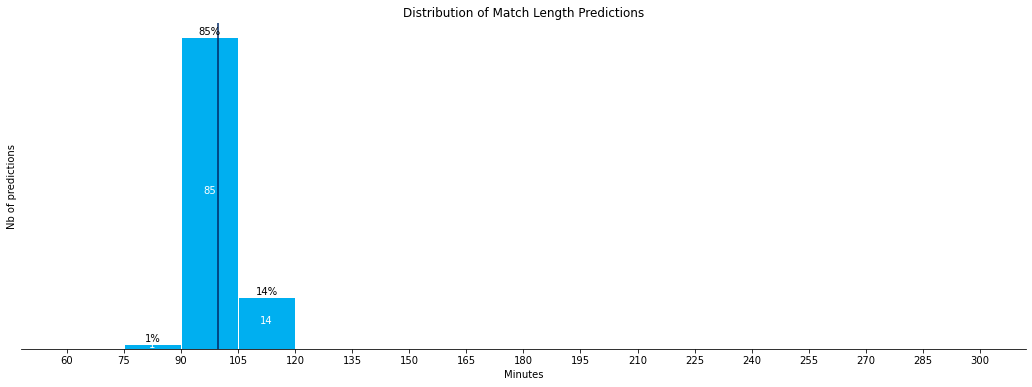

In [156]:
### HISTOGRAM ###

# ATP Colors
# Dark blue : #002865
# Light blue : #00AFF0

time_step = 15  # precision : 15/30/30 minutes
intervals=np.arange(60, 300 + time_step, time_step)

fig, ax = plt.subplots(1, figsize=(18,6))

n, bins, patches = plt.hist(predictions, bins=intervals, color='#00AFF0')

plt.xticks(bins)
plt.grid(color='white', lw = 1, axis='x')

plt.title('Distribution of Match Length Predictions')
plt.xlabel("Minutes")
plt.ylabel("Nb of predictions")

# ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

xticks = [(bins[idx+1] + value)/2 for idx, value in enumerate(bins[:-1])]
plt.yticks([])

for idx, value in enumerate(n) :
    if value > 0 :
        plt.text(xticks[idx], value + 1, f"{int(100 * value / iter)}%", ha='center')
        plt.text(xticks[idx], value / 2, int(value), ha='center', color='w')

plt.axvline(x=average_prediction, color='#002865')

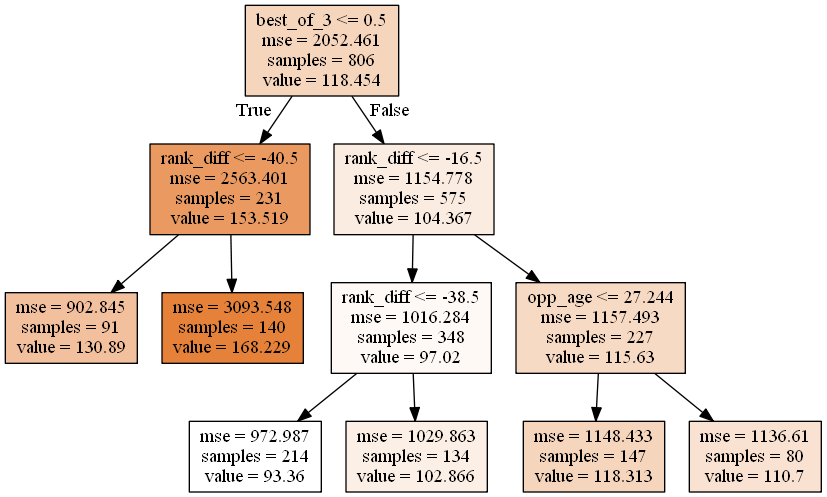

In [153]:
# TREE VISUALIZATION

# Without True/False (sklearn)

# x_ax = range(len(ytest))
# plt.plot(x_ax, ytest, linewidth=1, label="original")
# plt.plot(x_ax, ypred, linewidth=1.1, label="predicted")
# plt.title("Y-test and y-predicted data")
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')
# plt.legend(loc='best',fancybox=True, shadow=True)
# plt.grid(True)
# plt.show()

# plt.figure(figsize=(30,15))
# tree.plot_tree(dtr,
#           filled=True,
#           rounded=True,
#           fontsize=10,
#           feature_names=["opp_ht", "opp_age", "rank_diff", "consecutive", "surface_Carpet", "surface_Clay", "surface_Grass", "surface_Hard", 
#                          "best_of_3", "best_of_5", "opp_hand_L", "opp_hand_R", 
#                          'tourney_level_A', 'tourney_level_D', 'tourney_level_F', 'tourney_level_G', 'tourney_level_M', 
#                          'round_F', 'round_QF', 'round_R128', 'round_R16', 'round_R32', 'round_R64', 'round_RR', 'round_SF'])

# # plt.savefig('tree_high_dpi', dpi=600)

# # With True/False label (pydot)

from IPython.display import Image
from six import StringIO
from sklearn.tree import export_graphviz
import pydot

# def visualize_tree(dtr) :

features = list(player1.columns)
features.remove("minutes")

dot_data = StringIO()
export_graphviz(dtr, out_file=dot_data, feature_names=features, filled=True)
graph = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph[0].create_png())

# visualize_tree(dtr)